# Analysis of ascent fraction changes in 2D mock-Walker SAM simulations
Adam Sokol<br>
September 2025

In [1]:
import xarray as xr, numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker

import constants as const
import glob, copy, os
from importlib import reload
#import sam
import sat
from cycler import cycler
import seaborn as sns
import pandas as pd
import cmocean
import warnings
warnings.filterwarnings('ignore')

## Load output

In [19]:
data_dir = './data/'
mean = xr.open_dataset('./data/SAM_MockWalker2D_AllCases_day150-300.nc')

mean = mean.sel(p=slice(None,None,-1)) # set pressure high to low

In [31]:
# Add fields
Lx = 3072 * 3000 # domain length (m)

# water vapor terms
mean['QTOTADV2D'] = mean.QTOTEDDY2D - mean.LHF/const.Lv # total advcetive flux (mean+eddy) kg/m2/s
mean['F'] = const.Lv*mean.QTOTADV2D.where(mean.up).mean('x') * mean.sigma_c # Equal to flux of WV  into rainy region at its boundaries normalized by domain length

# domain avg previp
mean['P'] = mean.PREC.mean('x')

# horizontal convergence
mean['conv'] = -mean.U.differentiate('x') # convergence 1/s

# ascent region average
conv = mean.where(mean.up).mean('x') # average over convective region

# fraction of total precip falling in ascent region
mean['alpha'] = conv.sigma_c * conv.PREC / mean.PREC.mean('x') 

# tropopause pressure
mean['p_top'] = conv.p.where(conv.OMEGA>0).sel(p=slice(300,0)).max('p')

# pressure at the top of the convergence layer
mean['ptop'] = conv.p.where(conv.conv < 0).max('p') # top of low-level inflow layer

# column-integrated MSE advection terms
mean['FMSEMADV2D'] = (mean.FMSEMADV*mean.dp*const.cp/const.g).where(mean.p>=mean.p_top).sum('p')*100/86400  # W/m2
mean['FMSEHADV2D'] = (mean.FMSEHADV*mean.dp*const.cp/const.g).where(mean.p>=mean.p_top).sum('p')*100/86400  # W/m2
mean['FMSEVADV2D'] = (mean.FMSEVADV*mean.dp*const.cp/const.g).where(mean.p>=mean.p_top).sum('p')*100/86400  # W/m2
mean['FMSEEADV2D'] = mean.FMSEADV2D - mean.FMSEMADV2D # eddy as residual from total advective fluxes calculated online

# Circulation strength -- largest value of ascent-region average omega profile
mean['wstar'] = conv.OMEGA.min('p') # circulation strength 

mean['GMSM'] = conv.FMSEMADV2D / mean.wstar # GMS/g (mean-flow only, does not include eddy MSE advection)
mean['GMSH'] = conv.FMSEHADV2D / mean.wstar # GMS/g component from horizontal advection
mean['GMSV'] = conv.FMSEVADV2D / mean.wstar # GMS/g component from vertical advection

#mean['FMSEHADV2Dlow'] = (mean.FMSEHADV * mean.dp * 100 * const.cp / const.g).where(mean.p>mean.ptop).sum('p')  / 86400
#mean['FMSEHADV2Dmid'] = (mean.FMSEHADV * mean.dp * 100 * const.cp / const.g).where((mean.p<=mean.ptop)&(mean.p>mean.ptopmid)).sum('p') / 86400
#mean['FMSEHADV2Dupper'] = (mean.FMSEHADV * mean.dp * 100 * const.cp / const.g).where(mean.p<=mean.ptopmid).sum('p') / 86400

#mean['FMSEHADV2D800'] = (mean.FMSEHADV * mean.dp * 100 * const.cp / const.g).sel(p=slice(1010,800)).sum('p')  / 86400
#mean['FMSEHADV2D600'] = (mean.FMSEHADV * mean.dp * 100 * const.cp / const.g).sel(p=slice(799,600)).sum('p')  / 86400
#mean['FMSEHADV2D400'] = (mean.FMSEHADV * mean.dp * 100 * const.cp / const.g).sel(p=slice(599,400)).sum('p')  / 86400
#mean['FMSEHADV2D100'] = (mean.FMSEHADV * mean.dp * 100 * const.cp / const.g).sel(p=slice(399,100)).sum('p')  / 86400

conv = mean.where(mean.up).mean('x') # average over convective region
#mean['GMSHlow'] = conv.FMSEHADV2Dlow /     conv.wstar
#mean['GMSHmid'] = conv.FMSEHADV2Dmid /     conv.wstar
#mean['GMSHupper'] = conv.FMSEHADV2Dupper / conv.wstar

#for ll in ['800','600','400','100']:
#    mean[f'GMSH{ll}'] = conv[f'FMSEHADV2D{ll}'] / conv.col_OMEGA

# moisture flux convergence approximation (Eq 10)
mean['Cq'] = (conv.conv * conv.SPHUM * conv.dp * 100 / const.g).sum('p')

# atmospheric diabatic forcing, including eddy (wstar = -Qatm/GMSM)
mean['Qatm'] = mean.DRAD + mean.LHF + mean.SHF + mean.FMSEEADV2D

# find edges of convective region
dx = np.diff(mean.x)[0]
mean['x0'] = mean.x.where(mean.up).min('x').load() - (dx/2)  # left edge of convective region
mean['x1'] = mean.x.where(mean.up).max('x').load() + (dx/2)  # right edge of convective region

# profiles on edge of convective region
mean['Uedge'] = (mean.U.interp(x=mean.x0) - mean.U.interp(x=mean.x1))/2 # takes the average magnitude between both edges (positive = inflow)
mean['FMSEedge'] = (mean.FMSE.interp(x=mean.x0) + mean.FMSE.interp(x=mean.x1))/2

# normalized inflow profile
mean['uhat'] = -mean.Uedge / (mean.wstar * mean.sigma_c * Lx)

# average over ascent region with new fields
conv = mean.where(mean.up).mean('x')

## Figure settings & colors

In [32]:
sns.set_context('paper')
mpl.rcParams['figure.figsize']  = (4, 3)
mpl.rcParams['ytick.labelsize']  = 'small'
mpl.rcParams['xtick.labelsize']  = 'small'

colors_exp = [mpl.cm.Blues(0.85), mpl.cm.Blues(0.58), mpl.cm.Greys(0.75), mpl.cm.Reds(0.9), mpl.cm.Reds(0.54), mpl.cm.Reds(0.3)]#, mpl.cm.Greys(0.5)]
colors_sst = [cmocean.cm.solar(ii) for ii in np.linspace(0.1,0.92,6)]
with plt.style.context('fivethirtyeight'):
    colors_538 = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('default')
color_dict = {'exp':colors_exp, 'sst':colors_sst, '538':colors_538}
def set_colors(color_set):
    mpl.rcParams['axes.prop_cycle'] = cycler('color', color_dict[color_set])

# Fig 1 new: wet-gets-drier

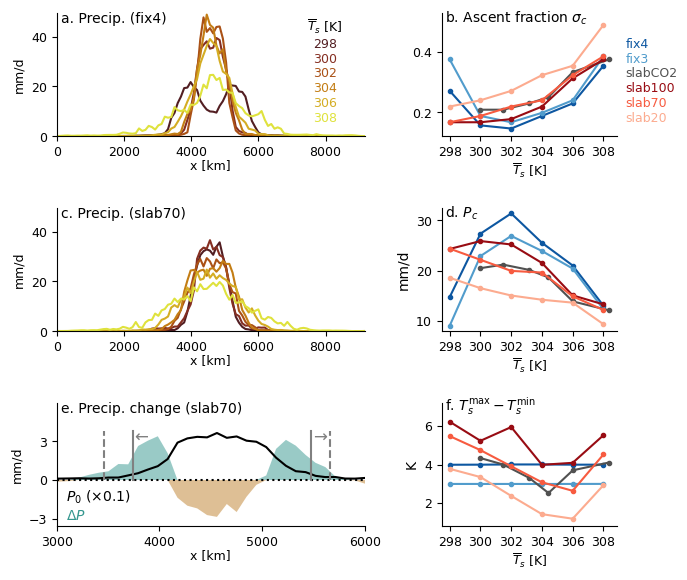

In [33]:
# sns.set_context('paper')
set_colors('sst')
# Create figure
fig = plt.figure(figsize=(7, 6.5))

ax1 = fig.add_axes([0.1, 0.7, 0.44, 0.19]) # precip fixed4
ax2 = fig.add_axes([0.1, 0.4, 0.44, 0.19]) # precip slab70
ax3 = fig.add_axes([0.1, 0.1, 0.44, 0.19]) # sst spread

ax4 = fig.add_axes([0.65, 0.7, 0.25, 0.19]) # mean precip within ascent region
ax5 = fig.add_axes([0.65, 0.4, 0.25, 0.19]) # mean precip within ascent region
ax6 = fig.add_axes([0.65, 0.1, 0.25, 0.19]) # mean precip within ascent region

axes = [ax1,ax2,ax3,ax4,ax5,ax6]

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=9)
    for ss in ['top','right']:
        ax.spines[ss].set_visible(False)

# top left: precip in fixed4
(86400*mean.PREC/const.Lv).isel(exp=0).plot.line(ax=ax1, x='x', add_legend=False, xlim=(0,mean.x.max()), ylim=(0,49.5))
ax1.set_xticks(np.arange(0,10e6,2e6)),  ax1.set_xticklabels(['0','2000','4000','6000','8000']),
ax1.text(0.015, 0.92, 'a. Precip. (fix4)', transform=ax1.transAxes)

for i, sst in enumerate(mean.sst.values):
    ax1.text(0.87, 0.72-i*0.12, str(int(sst)), color=colors_sst[i], fontsize=9, ha='center', transform=ax1.transAxes)
ax1.text(0.87, 0.85, r'$\overline{T}_s$ [K]', ha='center', fontsize=9, transform=ax1.transAxes)

    
# middle left: precip in slab70
(86400*mean.PREC/const.Lv).isel(exp=4).plot.line(ax=ax2, x='x', add_legend=False, xlim=(0,mean.x.max()), ylim=(0,49.5))
ax2.set_xticks(np.arange(0,10e6,2e6)), ax2.set_xticklabels(['0','2000','4000','6000','8000'])
ax2.text(0.015, 0.92, r'c. Precip. (slab70)', transform=ax2.transAxes)


# lower left: precip change in slab70
dP = (mean.sel(sst=304)-mean.sel(sst=300)).sel(exp='slab70').PREC.values*86400/const.Lv/4
ax3.fill_between(mean.x/1000, 0*mean.x, np.where(dP>0, dP, 0), color=mpl.cm.BrBG(0.8), alpha=0.5, edgecolor='None')
ax3.fill_between(mean.x/1000, 0*mean.x, np.where(dP<0, dP, 0), color=mpl.cm.BrBG(0.2), alpha=0.5, edgecolor='None')
ax3.set_ylim(-3.6,6.), ax3.set_xlim(3000,6000)
ax3.set_xticks(np.arange(3e3,7e3,1e3))
ax3.set_yticks([-3,0,3])
ax3.axhline(color='k', ls=':')
p0 = mean.sel(exp='slab70', sst=300).PREC*86400/const.Lv
ax3.plot(p0.x/1000, p0/10, color='k')
ax3.set_xticks(np.arange(3e3,7e3,1e3))
ax3.plot(2*[mean.sel(sst=300,exp='slab70').x0/1000], [0, 3.8], color='grey', ls='-')
ax3.plot(2*[mean.sel(sst=300,exp='slab70').x1/1000], [0, 3.8], color='grey', ls='-')
ax3.plot(2*[mean.sel(sst=304,exp='slab70').x0/1000], [0, 3.8], color='grey', ls='--')
ax3.plot(2*[mean.sel(sst=304,exp='slab70').x1/1000], [0, 3.8], color='grey', ls='--')
ax3.spines.top.set_visible(False)

ax3.text(3720, 3.1, r'$\leftarrow$', color='grey', fontsize=12)
ax3.text(5470, 3.1, r'$\rightarrow$', color='grey', fontsize=12)
ax3.text(0.03, 0.05, r'$\Delta P$', color=mpl.cm.BrBG(0.8), transform=ax3.transAxes, ha='left')
ax3.text(0.03, 0.20, r'$P_0$ ($\times$0.1)', transform=ax3.transAxes, ha='left')
ax3.text(0.015, 0.92, r'e. Precip. change (slab70)', transform=ax3.transAxes, fontsize=10)

# left column universal stuff
for ax in axes[:3]:
    ax.set_title('')
    ax.set_ylabel('mm/d', fontsize=9)
    ax.set_xlabel('x [km]', fontsize=9, labelpad=-0)

#right side: ascent fraction, precip in ascent region, SST gradients
for i in range(mean.sizes['exp']):
    ax4.plot(mean.meanSST.isel(exp=i), mean.sigma_c.isel(exp=i), color=colors_exp[i], marker='o', markersize=3)
    ax5.plot(mean.meanSST.isel(exp=i), 86400*conv.PREC.isel(exp=i)/const.Lv, color=colors_exp[i], marker='o', markersize=3)
    ax6.plot(mean.meanSST.isel(exp=i), (mean.SST.max('x')-mean.SST.min('x')).isel(exp=i), color=colors_exp[i], marker='o', markersize=3)

for ax in axes[3:]:
    ax.set_xticks(np.arange(298,310,2))
    ax.set_xlabel('')
    ax.set_xlabel(r'$\overline{T}_s$ [K]', labelpad=2, fontsize=9)

# top right: ascent fraction
for i, exp in enumerate(mean.exp.values):
    ax4.text(1.05, 0.72-i*0.12, exp, color=colors_exp[i], fontsize=9, ha='left', transform=ax4.transAxes)
ax4.set_ylim(0.12,0.53)
ax4.text(0.02, 0.92, r'b. Ascent fraction $\sigma_c$', transform=ax4.transAxes)

# middle right: precip in the ascent region
ax5.set_ylabel('mm/d')
ax5.text(0.02, 0.92, 'd. $P_c$', transform=ax5.transAxes)

# lower right: SST gradients
ax6.set_ylim(0.8,7.2)
ax6.set_ylabel('K')
ax6.text(0.02, 0.94, r'f. $T_s^{\text{max}}-T_s^{\text{min}}$', transform=ax6.transAxes)
plt.savefig('figures/fig1.pdf', bbox_inches='tight')

# Fig 2: moisture budget

In [34]:
set_colors('538')

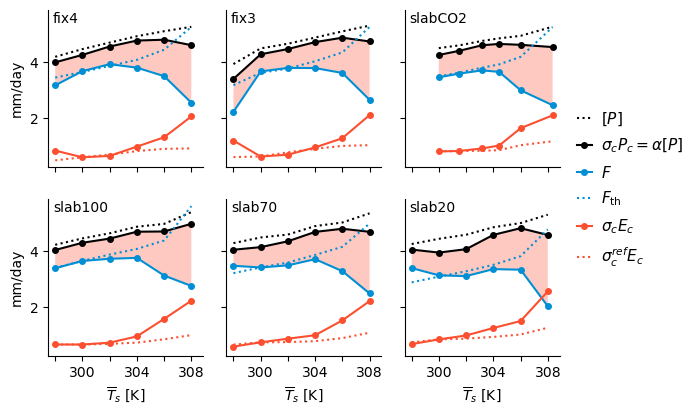

In [35]:
fig, axes = plt.subplots(2, 3, figsize=(6.6,4.5), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.2, wspace=0.15)
axesf = axes.ravel(order='C')
fac = 86400 / const.Lv
for iexp in range(mean.sizes['exp']):
    plt.sca(axesf[iexp])
    tmp = mean.isel(exp=iexp)
    ctmp = conv.isel(exp=iexp)

    norm = ctmp.isel(sst=1)#ctmp.sigma_c.argmin('sst').values) # reference values -- reference SST is the one with minimum sigma_c for each simulation set
    
    alpha = tmp.alpha
    plt.plot(tmp.meanSST, fac*tmp.PREC.mean('x'), color='k', ls=':', label=r'$[P]$')
    plt.plot(tmp.meanSST, alpha*fac*tmp.PREC.mean('x'), color='k', marker='o', markersize=4, label=r'$\sigma_c P_c = \alpha [P]$')
    
    Fline = plt.plot(tmp.meanSST, fac*tmp.F, marker='o', markersize=4, label=r'$F$',)
    # This is what F would be if the dynamics were held fixed at the reference SST but the moisture was allowed to change
    F_therm = norm.sigma_c * (ctmp.SPHUM*norm.conv*ctmp.dp*100/const.g).sum('p')
    plt.plot(tmp.meanSST, 86400*F_therm, ls=':', color=Fline[0].get_color(), label=r'$F_{\text{th}}$')

    plt.fill_between(tmp.meanSST, fac*tmp.F, alpha*fac*tmp.PREC.mean('x'), color=colors_538[1], alpha=0.3, edgecolor='None')
    plt.plot(tmp.meanSST, fac*ctmp.sigma_c*ctmp.LHF, marker='o', markersize=4, label=r'$\sigma_c E_c$')
    plt.plot(tmp.meanSST, fac*norm.sigma_c*ctmp.LHF, ls=':', color=colors_538[1], label=r'$\sigma_c^{ref} E_c$')
    plt.title('')
    plt.text(0.03, 0.92, mean.exp.values[iexp], transform=axesf[iexp].transAxes)
    plt.xticks(np.arange(298,310,2))
    [axesf[iexp].spines[ss].set_visible(False) for ss in ['top','right']]

for ax in axes[1,:]:
    ax.set_xlabel(r'$\overline{T}_s$ [K]')
    ax.set_xticklabels(['','300','','304','','308'])
for ax in axes[:,0]:
    ax.set_ylabel(r'mm/day')
plt.sca(axes[0,-1])
plt.legend(frameon=False, bbox_to_anchor=[1.02,0.45], loc='upper left', handlelength=1, handletextpad=0.6, labelspacing=0.6, fontsize=11)
plt.savefig('figures/fig2.pdf', bbox_inches='tight')


# Fig 3. Circulation strength and GMS

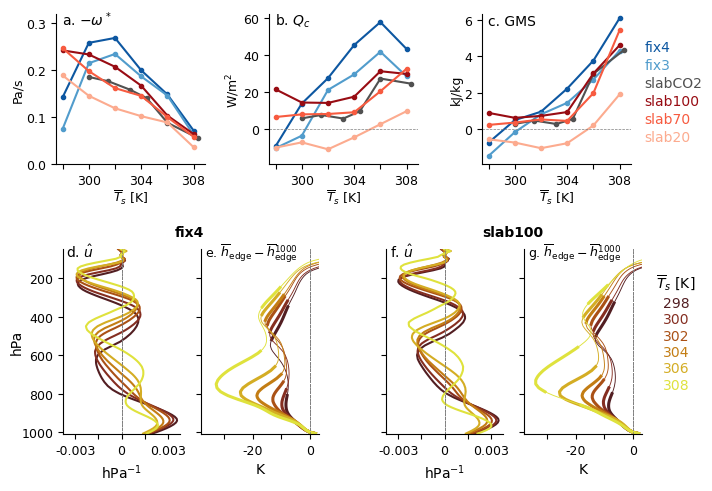

In [37]:
set_colors('sst')
fig = plt.figure(figsize=(7.1, 5))

# Manual axes placement: [left, bottom, width, height]
axes_circ = [
    fig.add_axes([0.06, 0.64, 0.21, 0.3]),  # circulation strength
    fig.add_axes([0.36, 0.64, 0.21, 0.3]),  # diabatic forcing
    fig.add_axes([0.66, 0.64, 0.21, 0.3])   # GMS
]

axm = [
    fig.add_axes([0.07, 0.1, 0.165, 0.37]),  # fix4 - u
    fig.add_axes([0.265, 0.1, 0.165, 0.37]), # fix4 - MSE
    fig.add_axes([0.525, 0.1, 0.165, 0.37]), # slab100 - u
    fig.add_axes([0.72, 0.1, 0.165, 0.37]), # slab100 - MSE
]

for ax in axm+axes_circ:
    [ax.spines[ss].set_visible(False) for ss in ['top','right']]
    ax.tick_params(axis='both', labelsize=9)


# Top row: Circulation, diabatic forcing, and GMS trends
for iexp in range(mean.sizes['exp']):
    axes_circ[0].plot(mean.meanSST.isel(exp=iexp), -conv.wstar.isel(exp=iexp), marker='o', markersize=3, color=colors_exp[iexp])
    axes_circ[1].plot(mean.meanSST.isel(exp=iexp), conv.Qatm.isel(exp=iexp), marker='o', markersize=3, label=mean.exp.values[iexp], color=colors_exp[iexp])
    axes_circ[2].plot(mean.meanSST.isel(exp=iexp), const.g*(conv.FMSEMADV2D/conv.wstar/1000).isel(exp=iexp), marker='o', markersize=3, label=mean.exp.values[iexp], color=colors_exp[iexp])
axes_circ[0].set_ylim(0.0,0.32)
axes_circ[1].set_ylim(-19,62)
axes_circ[2].set_ylim(-1.9,6.3)

titles = [r'a. $-\omega^*$', r'b. $Q_c$', r'c. GMS']
ylabels = ['Pa/s', 'W/m$^2$', 'kJ/kg']

for i, ax in enumerate(axes_circ):
    ax.set_ylabel(ylabels[i], labelpad=1, fontsize=9)
    ax.set_title('')
    ax.text(0.04,0.93, titles[i], transform=ax.transAxes, fontsize=10)
    ax.set_xticks(np.arange(298, 310, 2))
    ax.set_xticklabels(['', '300', '', '304', '', '308'])
    ax.set_xlabel(r'$\overline{T}_s$ [K]', fontsize=9, labelpad=1)
    if i > 0:
        ax.axhline(color='tab:grey', ls='--', lw=0.5)
        
# MSE/omega hat 
for iexp, exp in enumerate(['fix4', 'slab100']):
    if iexp==0:
        axr = axm[:2]
    else:
        axr=axm[2:]
    for isst in range(mean.sizes['sst']):
        ctmp = conv.sel(exp=exp).isel(sst=isst)

        plt.sca(axr[0])
        data = 100 * ctmp.uhat # units: 1/hPa
        l = data.plot(y='p', ylim=(1010, 50), xlim=(-3.8e-3, 3.8e-3), color=colors_sst[isst])
        plt.ylabel(''), plt.title(''), plt.xlabel('hPa$^{-1}$', fontsize=10)
        plt.xticks(np.arange(-3e-3, 4e-3, 1.5e-3), labels=['-0.003','','0','','0.003'])
        plt.axvline(color='tab:grey', ls='--', lw=0.5)

        plt.sca(axr[1])
        data = ctmp.FMSEedge - ctmp.FMSEedge.sel(p=1000)
        l = data.plot(y='p', ylim=(1010, 50), xlim=(-38,3), lw=0.65, color=colors_sst[isst], label=str(int(mean.sst.values[isst])))
        data.where(ctmp.uhat > 0).plot(y='p', lw=2.2, color=l[0].get_color())
        plt.axvline(color='tab:grey', ls='--', lw=0.5)
        plt.title(''), plt.xlabel('K', fontsize=10), plt.ylabel('')
        plt.xticks(np.arange(-30,10,10), labels=['','-20','','0'])
        
axm[0].set_ylabel('hPa', labelpad=-2, fontsize=10)
for ax in axm[1:]:
    ax.set_yticklabels(5*[''])

axm[0].text(0.03,0.96,r'd. $\hat{u}$', transform=axm[0].transAxes, fontsize=10)
axm[1].text(0.03,0.96,r'e. $\overline{h}_{\text{edge}}-\overline{h}_{\text{edge}}^{1000}$', transform=axm[1].transAxes, fontsize=9)
axm[2].text(0.03,0.96,r'f. $\hat{u}$', transform=axm[2].transAxes, fontsize=10)
axm[3].text(0.03,0.96,r'g. $\overline{h}_{\text{edge}}-\overline{h}_{\text{edge}}^{1000}$', transform=axm[3].transAxes, fontsize=9)
axm[1].text(-0.1, 1.07, 'fix4', fontsize=10,  ha='center', fontweight='bold', transform=axm[1].transAxes)
axm[3].text(-0.1, 1.07, 'slab100', fontsize=10, ha='center', fontweight='bold', transform=axm[3].transAxes)

ax = axm[-1]
for i, sst in enumerate(mean.sst.values):
    ax.text(15, 350+i*85, str(int(sst)), ha='center', color=colors_sst[i], fontsize=10)
ax.text(15, 250, r'$\overline{T}_s$ [K]', ha='center', fontsize=10, )

ax = axes_circ[2]
for i, exp in enumerate(mean.exp.values):
    ax.text(309.9, 4.3-i*0.99, exp, color=colors_exp[i], fontsize=10, ha='left')
plt.savefig('./figures/fig3.pdf', bbox_inches='tight')

# Fig 4: surface RH and MSE surplus

In [44]:
# "near-surface" variables defined as mass-weighted average between 950 and surface
mean['MSE'] = (const.cp*mean.TABS + const.Lv*mean.SPHUM + const.g*mean.z) / const.cp
mean['MSEbl'] = mean.MSE.sel(p=slice(1020,950)).weighted(mean.dp.sel(p=slice(1020,950))).mean('p')
mean['RHbl'] = mean.RH.sel(p=slice(1020,950)).weighted(mean.dp.sel(p=slice(1020,950))).mean('p')

In [45]:
conv = mean.where(mean.up).mean('x')

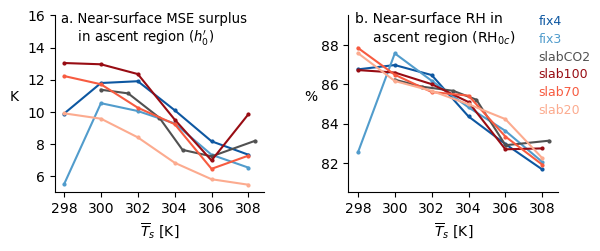

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(6.5,2.3))
fig.subplots_adjust(wspace=0.4)
set_colors('exp')
for iexp in range(mean.sizes['exp']):
    x = mean.meanSST.isel(exp=iexp).values
    axes[0].plot(x, (conv.MSEbl-mean.MSEbl.mean('x')).isel(exp=iexp), marker='o', markersize=2, color=colors_exp[iexp])
    axes[1].plot(x, 100*(conv.RHbl).isel(exp=iexp), marker='o', markersize=2, color=colors_exp[iexp])
#(conv.SPHUMbl/conv.SPHUMSATbl).plot.line(ax=axes[0], x='sst', marker='o', markersize=2, add_legend=False, ylim=(0.81, 0.89))
#(conv.MSEbl-mean.MSEbl.mean('x')).plot.line(ax=axes[1], x='sst', marker='o', markersize=2, add_legend=False, ylim=(5,14.8))
axes[0].set_ylim(5, 16)
axes[1].set_ylim(80.5, 89.5)

#axes[0].set_ylabel(r'$\frac{q_0}{q^*_0}$', rotation=0, fontsize=14, labelpad=10, y=0.4)
axes[1].set_ylabel('%', rotation=0, labelpad=7)
axes[0].set_ylabel('K', rotation=0, labelpad=9)
for ax in axes:
    [ax.spines[ss].set_visible(False) for ss in ['top','right']]
    ax.set_xticks(np.arange(298,310,2))
    #ax.set_xticklabels(['','300','','304','','308'])
    ax.set_xlabel(r'$\overline{T}_s$ [K]')
    
axes[0].text(0.03,1.02,'a. Near-surface MSE surplus\n    in ascent region ' +r"$(h_0')$", transform=axes[0].transAxes, va='top', fontsize=9.5)
axes[1].text(0.03,1.02,'b. Near-surface RH in\n    ascent region' + r" (RH$_{0c}$)", transform=axes[1].transAxes, va='top')

for i, exp in enumerate(mean.exp.values):
    axes[1].text(307.8, 89 - 0.9*i, exp, color=colors_exp[i], fontsize=9, ha='left')
plt.savefig('figures/fig4.pdf', bbox_inches='tight')

# SI Figures

## Moisture convergence approximation

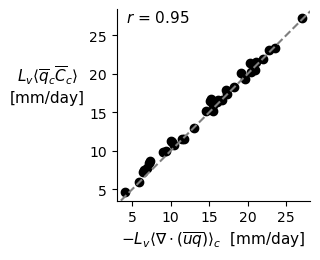

In [56]:
plt.figure(figsize=(2.5,2.5))
x1 = 86400*conv.QTOTADV2D 
x2 = 86400*conv.Cq
r = np.corrcoef(x1,x2)[0,1]
plt.scatter(x1, x2, color='k')
plt.axline([10,10], slope=1, color='tab:grey', ls='--')
plt.gca().set_aspect('equal')
plt.xlabel(r'$-L_v\langle \nabla\cdot(\overline{uq})\rangle_c$  [mm/day]', fontsize=11)
plt.ylabel(r'$L_v \langle \overline{q}_c \overline{C}_c \rangle$' + '\n' + '[mm/day]', rotation=0, labelpad=30, fontsize=11)
plt.text(0.05, 1.0, '$r$ = {:.2f}'.format(r), va='top', transform=plt.gca().transAxes, fontsize=11)
for ss in ['top','right']:
    plt.gca().spines[ss].set_visible(False)
plt.xticks(np.arange(5,30,5))
plt.savefig('./figures/SI_wv_flux_approx.pdf', bbox_inches='tight')

## $F_{th}$ and $F_{dy}$ in each simulation

In [57]:
fac = 86400 / const.Lv
Fs, Fcols = [], []
Fths, Fthcols = [], []
Fdyns, Fdyncols, Fdyncols2 = [], [], []
for iexp in range(mean.sizes['exp']):
    ctmp = conv.isel(exp=iexp)
    norm = ctmp.isel(sst=1)#ctmp.sigma_c.argmin('sst').values) # reference values -- reference SST is the one with minimum sigma_c for each simulation set
    F = 86400 * ctmp.sigma_c * (ctmp.SPHUM * ctmp.conv)
    Fth = 86400 * norm.sigma_c * (ctmp.SPHUM * norm.conv)
    Fdyn = 86400 * norm.sigma_c * (norm.SPHUM * ctmp.conv)
    Fs.append(F)
    Fths.append(Fth)
    Fdyns.append(Fdyn)
    Fcols.append((F*ctmp.dp*100/const.g).sum('p'))
    Fthcols.append((Fth*ctmp.dp*100/const.g).sum('p'))
    Fdyncols.append((Fdyn*ctmp.dp*100/const.g).sum('p'))
F = xr.concat(Fs, dim='exp')
Ft = xr.concat(Fths, dim='exp')
Fd = xr.concat(Fdyns, dim='exp')
Fc = xr.concat(Fcols, dim='exp')
Ftc = xr.concat(Fthcols, dim='exp')
Fdc = xr.concat(Fdyncols, dim='exp')

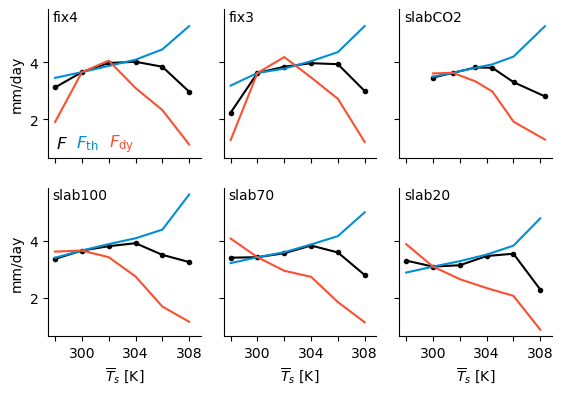

In [58]:
fig, axes = plt.subplots(2, 3, figsize=(6.5,4.25), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.2, wspace=0.15)
axesf = axes.ravel(order='C')
fac = 86400 / const.Lv
for iexp in range(mean.sizes['exp']):
    plt.sca(axesf[iexp])
    x = mean.meanSST.isel(exp=iexp)

    plt.plot(x, Fc.isel(exp=iexp), color='k', lw=1.5, markersize=3, marker='o')
    plt.plot(x, Ftc.isel(exp=iexp), color=colors_538[0],)
    #plt.plot(tmp.meanSST, Ftc2.isel(exp=iexp), color='k', ls='--',)
    plt.plot(x, Fdc.isel(exp=iexp), color=colors_538[1],)
    
    plt.title('')
    plt.text(0.03, 0.92, mean.exp.values[iexp], transform=axesf[iexp].transAxes)
    plt.xticks(np.arange(298,310,2))
    [axesf[iexp].spines[ss].set_visible(False) for ss in ['top','right']]

for ax in axes[1,:]:
    ax.set_xlabel(r'$\overline{T}_s$ [K]')
    ax.set_xticklabels(['','300','','304','','308'])
for ax in axes[:,0]:
    ax.set_ylabel(r'mm/day')

axes[0,0].text(298.5, 1, r'$F$', fontsize=12, ha='center')
axes[0,0].text(300.4, 1, r'$F_{\text{th}}$', color=colors_538[0], fontsize=12, ha='center')
axes[0,0].text(303, 1, r'$F_{\text{dy}}$', color=colors_538[1], fontsize=12, ha='center')

plt.sca(axes[0,-1])
plt.legend(frameon=False, bbox_to_anchor=[1.02,0.45], loc='upper left', handlelength=1, handletextpad=0.6, labelspacing=0.6)
plt.savefig('figures/SI_thermo_dyn.pdf', bbox_inches='tight')

## Ascent-region moisture budget terms

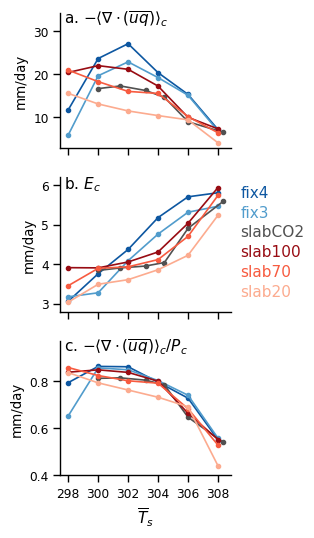

In [59]:
sns.set_context('paper')
fig, axes = plt.subplots(3, 1, figsize=(2.2, 6), sharex=True)
fig.subplots_adjust(hspace=0.22, wspace=0.3)
axesf = axes#.flatten()

adv_frac = const.Lv * conv.QTOTADV2D / conv.PREC
for iexp in range(mean.sizes['exp']):
    #axesf[0].plot(mean.meanSST.isel(exp=iexp), conv.PREC.isel(exp=iexp)/const.Lv*86400, marker='o', markersize=3, color=colors_exp[iexp])
    axesf[0].plot(mean.meanSST.isel(exp=iexp), conv.QTOTADV2D.isel(exp=iexp)*86400, marker='o', markersize=3, color=colors_exp[iexp])
    axesf[1].plot(mean.meanSST.isel(exp=iexp), conv.LHF.isel(exp=iexp)/const.Lv*86400, marker='o', markersize=3, color=colors_exp[iexp])
    
    axesf[2].plot(mean.meanSST.isel(exp=iexp), adv_frac.isel(exp=iexp), marker='o', markersize=3, color=colors_exp[iexp])
    #axesf[0].plot(mean.meanSST.isel(exp=iexp), adv_frac.isel(exp=iexp), marker='o', markersize=3, color=colors[iexp])

axesf[0].set_ylim(3, 34)
axesf[1].set_ylim(2.8, 6.2)
axesf[2].set_ylim(0.4,0.97)

#ax = axes[0]
for i, exp in enumerate(mean.exp.values):
    axes[1].text(309.5, 5.7-i*0.5, exp, color=colors_exp[i], fontsize=11, ha='left')
    
letters = 'abcd'
titles = [r'$-\langle\nabla\cdot(\overline{uq})\rangle_c$', r'$E_c$', r'$-\langle\nabla\cdot(\overline{uq})\rangle_c /P_c$']
for i,ax in enumerate(axesf):
    for ss in ['top','right']:
        ax.spines[ss].set_visible(False)
    ax.set_xticks(np.arange(298,310,2))
    ax.text(0.02, 0.92, letters[i] + '. ' + titles[i], transform=ax.transAxes, fontsize=11)
    if i<3:
        ax.set_ylabel('mm/day')
    if i>1:
        ax.set_xlabel(r'$\overline{T}_s$', fontsize=11)
plt.savefig('figures/SI_ascent_moisture_budget.pdf', bbox_inches='tight')

## $\hat{u}$ and $h_{edge}$ profiles for every simulation

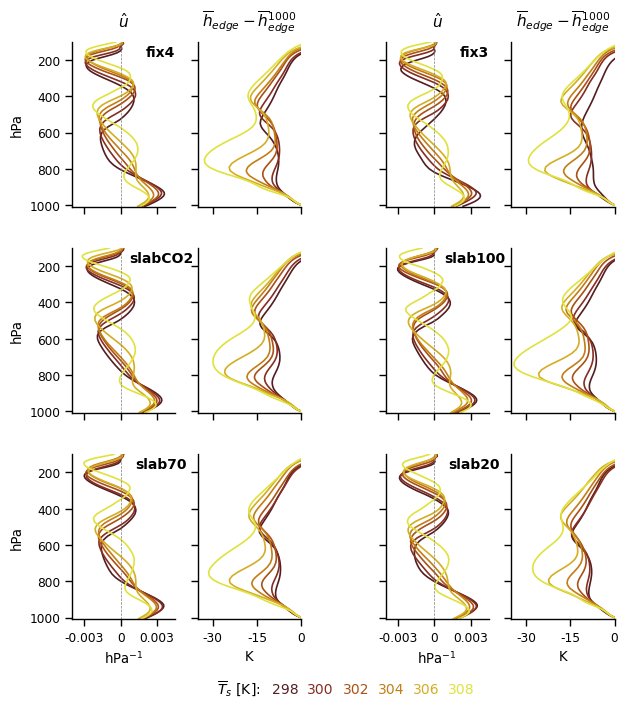

In [60]:
set_colors('sst')
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(7, 7.5))
gs = gridspec.GridSpec(3, 5, width_ratios=[1,1,0.38,1,1], wspace=0.25, hspace=0.25)
axes = np.empty((3,4), dtype=object)
for row in range(3):
    axes[row,0] = fig.add_subplot(gs[row,0])
    axes[row,1] = fig.add_subplot(gs[row,1])
    axes[row,2] = fig.add_subplot(gs[row,3])
    axes[row,3] = fig.add_subplot(gs[row,4])
for ax in axes.flatten():
    for ss in ['top','right']:
        ax.spines[ss].set_visible(False)

n_exp = len(mean.exp.values)
for iexp, exp in enumerate(mean.exp.values):
    row = iexp // 2
    col_offset = (iexp % 2) * 2
    axs = axes[row, col_offset:col_offset+2]
    ctmp = conv.sel(exp=exp).sel(p=slice(1010,100))

    plt.sca(axs[0])
    (ctmp.uhat*100).plot.line(y='p', ylim=(1010,100), add_legend=False)
    plt.title(''), plt.xlabel('')
    plt.xlim(-4e-3, 4.5e-3)
    plt.xticks([-0.003, 0, 0.003], labels=3*[''])
    if row == 2:
        plt.gca().set_xticklabels(['-0.003', '0', '0.003'])
        plt.xlabel('hPa$^{-1}$')
    if col_offset == 0:
        plt.gca().set_ylabel('hPa')
    else:
        plt.gca().set_ylabel('')
    plt.axvline(color='tab:grey', ls='--', lw=0.5)
    # exp label in top-right corner of left subplot in pair
    axs[0].text(0.86, 0.98, exp, va='top', ha='center', transform=axs[0].transAxes, fontsize=10, fontweight='bold')

    plt.sca(axs[1])
    (ctmp.FMSEedge-ctmp.FMSEedge.sel(p=1000)).plot.line(y='p', ylim=(1010,100), add_legend=False)
    plt.title(''), plt.xlabel(''), plt.ylabel('')
    plt.xlim(-35,0)
    plt.xticks([-30,-15,0], labels=3*[''])
    plt.yticks(np.arange(200,1200,200))
    if row == 2:
        plt.gca().set_xticklabels(['-30','-15','0'])
        plt.xlabel(r'K')
    plt.gca().set_ylabel('')

# Set column titles above top row
axes[0,0].set_title(r'$\hat{u}$', fontsize=11, y=1.04)
axes[0,1].set_title(r'$\overline{h}_{edge}-\overline{h}_{edge}^{1000}$', fontsize=11, y=1.04)
axes[0,2].set_title(r'$\hat{u}$', fontsize=11, y=1.04)
axes[0,3].set_title(r'$\overline{h}_{edge}-\overline{h}_{edge}^{1000}$', fontsize=11, y=1.04)
# Only left-most subplot in each row gets y label and ticks
for row in range(3):
    for col in range(4):
        if col != 0:
            axes[row, col].set_yticklabels([])
            axes[row, col].set_ylabel('')
        if row != 2:
            axes[row, col].set_xticklabels([])

ax = axes[2,1]
for i, sst in enumerate(mean.sst.values):
    ax.text(0.85+i*0.34, -0.45, str(int(sst)), ha='center', color=colors_sst[i], fontsize=10, transform=ax.transAxes)
ax.text(0.4, -0.45, r'$\overline{T}_s$ [K]:', ha='center', fontsize=10, transform=ax.transAxes)

plt.savefig('figures/SI_mse_uhat_profiles.pdf', bbox_inches='tight')

## $GMS$, $GMS_H$, and $GMS_V$ changes with warming

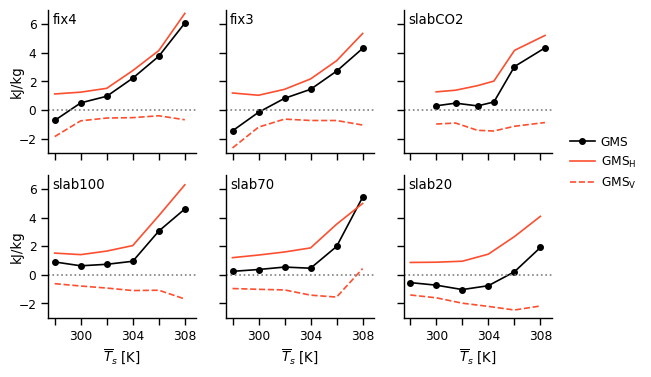

In [62]:
fig, axes = plt.subplots(2, 3, figsize=(6.5,4), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.15)
axesf = axes.ravel(order='C')
axesr = []
for iexp in range(mean.sizes['exp']):
    
    plt.sca(axesf[iexp])
    tmp = mean.isel(exp=iexp)
    ctmp = conv.isel(exp=iexp)
    c2 = colors_538[1]

    fac = const.g/1000
    plt.plot(ctmp.meanSST, fac*ctmp.FMSEMADV2D/ctmp.wstar, color='k', marker='o', markersize=4, label='GMS')
    plt.plot(ctmp.meanSST, fac*ctmp.FMSEHADV2D/ctmp.wstar, color=c2, label=r'GMS$_\text{H}$')
    plt.plot(ctmp.meanSST, fac*ctmp.FMSEVADV2D/ctmp.wstar, color=c2, ls='--', label=r'GMS$_\text{V}$')

    plt.text(0.03, 0.9, mean.exp.values[iexp], transform=plt.gca().transAxes)#plt.title(mean.exp.values[iexp], y=0.98)
    plt.xticks(np.arange(298,310,2))
    plt.ylim(-3,7)

    plt.axhline(color='tab:grey', ls=':')
    [plt.gca().spines[ss].set_visible(False) for ss in ['top','right']]
for ax in axes[1,:]:
    ax.set_xlabel(r'$\overline{T}_s$ [K]')
    ax.set_xticklabels(['','300','','304','','308'])
for ax in axes[:,0]:
    ax.set_ylabel(r'kJ/kg', labelpad=-4)

plt.sca(axes[0,-1])
axesf[2].legend(frameon=False, bbox_to_anchor=[1.05, 0.2], loc='upper left',  handletextpad=0.5)
plt.savefig('./figures/SI_GMS_components.pdf', bbox_inches='tight')

## Ascent region full MSE budget

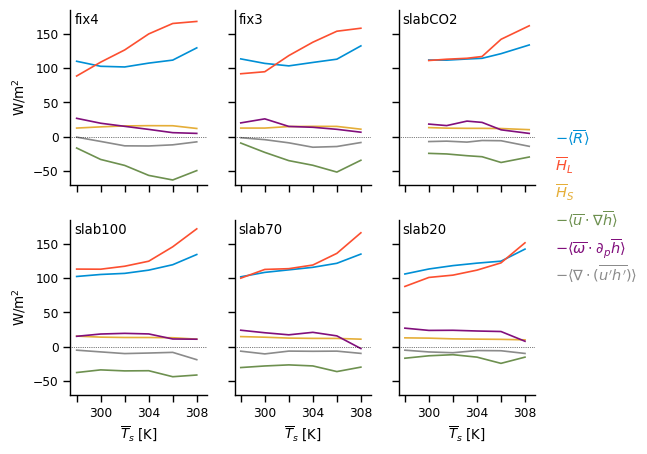

In [63]:
clrs=colors_538
fig, axes = plt.subplots(2, 3, figsize=(6,5), sharex=True, sharey=True )
fig.subplots_adjust(hspace=0.2, wspace=0.2)
axesf = axes.ravel(order='C')

for iexp in range(mean.sizes['exp']):
    tmp = conv.isel(exp=iexp)
    plt.sca(axesf[iexp])
    
    plt.plot(tmp.meanSST, -tmp.DRAD,      color=clrs[0])
    plt.plot(tmp.meanSST, tmp.LHF,        color=clrs[1])
    plt.plot(tmp.meanSST, tmp.SHF,        color=clrs[2])
    plt.plot(tmp.meanSST, tmp.FMSEHADV2D, color=clrs[3])
    plt.plot(tmp.meanSST, tmp.FMSEVADV2D, color=clrs[5])
    plt.plot(tmp.meanSST, tmp.FMSEEADV2D, color=clrs[4])
    #plt.grid(lw=0.5
    plt.axhline(color='k', ls=':', lw=0.5)
    plt.ylabel('')
    plt.xticks(np.arange(298,310,2), labels=['','300','','304','','308'])
    plt.title('')
    plt.ylim(-70,185)
    plt.text(0.03, 0.92, mean.exp.values[iexp], transform=axesf[iexp].transAxes)
    
        
    for ss in ['top','right']:
        plt.gca().spines[ss].set_visible(False)

labels = [r'$-\langle \overline{R} \rangle$', 
          r'$\overline{H}_L$',
          r'$\overline{H}_S$',
          r'$-\langle \overline{u}\cdot \nabla \overline{h} \rangle$',
          r'$-\langle \overline{\omega}\cdot \partial_p \overline{h} \rangle$',
          r"$-\langle \nabla \cdot (\overline{u'h'})\rangle$"
         ]

for i, lab in enumerate(labels):
    c = clrs[i] if i<4 else clrs[5] if i==4 else clrs[4]
    axes[0,2].text(310.5, -10-i*40, labels[i], fontsize=10.5, color=c)

for ax in axes[:,0]:
    ax.set_ylabel('W/m$^2$')
for ax in axes[1,:]:
    ax.set_xlabel(r'$\overline{T}_s$ [K]')
plt.savefig('figures/SI_MSE_budget.pdf', bbox_inches='tight')

## 3D simulations

In [64]:
def pp(dd):
    dd['wstar'] = dd.OMEGA.where(dd.up).mean('x').min('p')
    dd['circ'] = -dd.wstar
    return dd
    
dsf3d = pp(xr.open_mfdataset([data_dir +  f'fixed3d_nx3072_d75-150.nc']))
ds73d = pp(xr.open_mfdataset([data_dir +  f'slabmw3d_ds70_nx3072_d100-250.nc']))

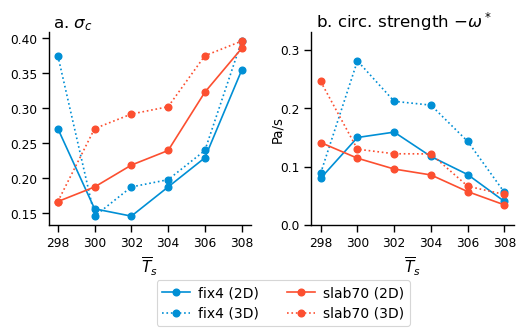

In [70]:
sns.set_context('paper')
fig, axes = plt.subplots(1, 2, figsize=(6,2.5))
fig.subplots_adjust(wspace=0.3)
plt.sca(axes[0])
mean.sigma_c.isel(exp=0).plot.line(x='sst', color=colors_538[0], marker='o', label=mean.exp.values[0]+' (2D)')
dsf3d.sigma_c.plot.line(x='sst', color=colors_538[0], marker='o', ls=':', label=mean.exp.values[0]+' (3D)')
mean.sigma_c.isel(exp=4).plot.line(x='sst', color=colors_538[1], marker='o', label=mean.exp.values[4]+' (2D)')
ds73d.sigma_c.plot.line(x='sst', color=colors_538[1], marker='o', ls=':', label=mean.exp.values[4]+' (3D)')
plt.xlabel(r'$\overline{T}_s$', fontsize=11)
plt.ylabel('')
plt.text(0.02, 1, r'a. $\sigma_c$', va='bottom', transform=axes[0].transAxes, fontsize=12)

plt.sca(axes[1])
mean.circ.isel(exp=0).plot.line(x='sst', color=colors_538[0], marker='o', label=mean.exp.values[0]+' (2D)')
dsf3d.circ.plot.line(x='sst', color=colors_538[0], marker='o', ls=':', label=mean.exp.values[0]+' (3D)')
mean.circ.isel(exp=4).plot.line(x='sst', color=colors_538[1], marker='o', label=mean.exp.values[4]+' (2D)')
ds73d.circ.plot.line(x='sst', color=colors_538[1], marker='o', ls=':', label=mean.exp.values[4]+' (3D)', ylim=(0, 0.33))
plt.xlabel(r'$\overline{T}_s$', fontsize=11)
plt.ylabel('Pa/s', labelpad=-3)#r'$-\omega^*$', rotation=0, labelpad=8, fontsize=11)
plt.text(0.02, 1, r'b. circ. strength $-\omega^*$', va='bottom', transform=axes[1].transAxes, fontsize=12)
plt.yticks(np.arange(0,0.4,0.1))

for ax in axes:
    ax.set_xticks(np.arange(298, 310, 2))
    for ss in ['top','right']:
        ax.spines[ss].set_visible(False)
    
axes[0].legend(frameon=True, bbox_to_anchor=[0.5, -0.25], loc='upper left', fontsize=10, ncol=2, handletextpad=0.6, columnspacing=2)
#plt.legend(bbox_to_anchor=[0.5, -0.4], loc='center',ncol=2, fontsize=10, handletextpad=0.4, columnspacing=1.5)
plt.savefig('./figures/SI_2Dvs3D.pdf', bbox_inches='tight')

## Domain length sensitivity

In [53]:
# load output from shorter domain (nx=1536)
f1536_2 = xr.open_mfdataset([data_dir +  f'fixed2_nx1536_d150-300.nc']) # fixed SST dT=2
mw1536_70 = xr.open_mfdataset([data_dir +  f'slabmw_ds70_nx1536_d150-300.nc']) # slab dS=70

# load output from longer domain (nx=4608)
f4608_6 = xr.open_mfdataset([data_dir +  f'fixed6_nx4608_d150-300.nc']) # fixed SST dT=6
mw4608_70 = xr.open_mfdataset([data_dir +  f'slabmw_ds70_nx4608_d150-300.nc']) # slab dS=70


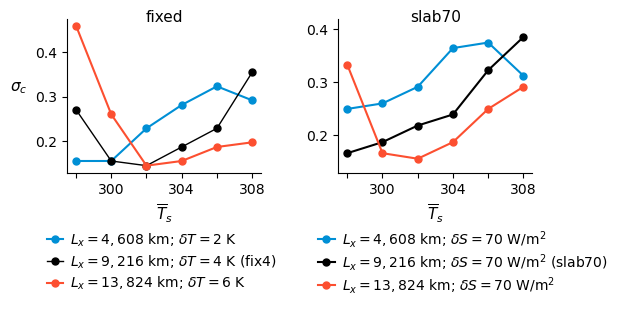

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(6, 2), sharex=True)
fig.subplots_adjust(wspace=0.4)

f1536_2.sigma_c.plot.line(ax=axes[0], x='sst', color=colors_538[0], markersize=5, marker='o', label=r'$L_x=4,608$ km; $\delta T=2$ K')
mean.sigma_c.isel(exp=0).plot.line(ax=axes[0], x='sst', color='k', marker='o', lw=1, markersize=5, label=r'$L_x=9,216$ km; $\delta T=4$ K (fix4)')
f4608_6.sigma_c.plot.line(ax=axes[0], x='sst', color=colors_538[1], markersize=5, marker='o', label=r'$L_x=13,824$ km; $\delta T=6$ K')

mw1536_70.sigma_c.plot.line(ax=axes[1], x='sst', color=colors_538[0],  marker='o', markersize=5, label=r'$L_x=4,608$ km; $\delta S=70$ W/m$^2$')
mean.sigma_c.isel(exp=4).plot.line(ax=axes[1], x='sst', color='k', marker='o', markersize=5, label=r'$L_x=9,216$ km; $\delta S=70$ W/m$^2$ (slab70)')
mw4608_70.sigma_c.plot.line(ax=axes[1], x='sst', color=colors_538[1], marker='o', markersize=5, label=r'$L_x=13,824$ km; $\delta S=70$ W/m$^2$')


axes[1].set_ylim(0.13,0.42)
axes[0].text(0.5, 0.98, 'fixed', transform=axes[0].transAxes, fontsize=11, ha='center')
axes[1].text(0.5, 0.98, mean.exp.values[4], transform=axes[1].transAxes, fontsize=11, ha='center')

for ax in axes:
    plt.sca(ax)
    plt.xlabel(r'$\overline{T}_s$', fontsize=11)
    plt.ylabel(''), plt.title('')
    for ss in ['top','right']:
        ax.spines[ss].set_visible(False)
    plt.xticks(np.arange(298,310,2), labels=['','300','','304','','308'])
axes[0].set_ylabel(r'$\sigma_c$', rotation=0, labelpad=12, fontsize=11)
axes[0].legend(bbox_to_anchor=[-0.17,-0.3], loc='upper left', frameon=False, handlelength=1.2, handletextpad=0.5, labelspacing=0.3)
axes[1].legend(bbox_to_anchor=[-0.17,-0.28], loc='upper left', frameon=False, handlelength=1.2, handletextpad=0.5, labelspacing=0.15)

plt.savefig('figures/SI_Lx_sensitivity.pdf', bbox_inches='tight')

## Wet-gets-drier pattern of $\Delta P$

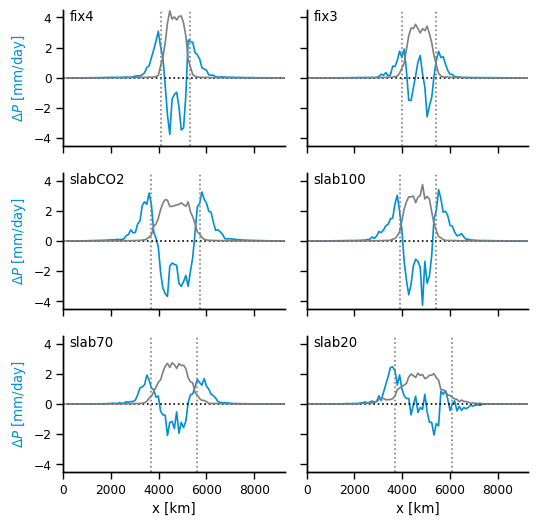

In [94]:
fig, axes = plt.subplots(3, 2, figsize=(6,6), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1)
axesf = axes.ravel(order='C')
axesr = []
for iexp, ax in enumerate(axesf):
    tmp = mean.isel(exp=iexp)
    ax = axesf[iexp]
    plt.sca(axesf[iexp])
    sst0 = 302
    sst1 = 306
    p0 = tmp.PREC.sel(sst=sst0)
    dP = ((tmp.PREC.sel(sst=sst1) - p0)/const.Lv*86400) / (tmp.meanSST.sel(sst=sst1) - tmp.meanSST.sel(sst=sst0))
    plt.plot(mean.x/1000, dP, color=colors_538[0])
    plt.axhline(color='k', ls=':')
    plt.axvline(x=tmp.x0.sel(sst=302)/1e3, color='tab:grey', ls=':')
    plt.axvline(x=tmp.x1.sel(sst=302)/1e3, color='tab:grey', ls=':')
    [ax.spines[ss].set_visible(False) for ss in ['top','right']]
    plt.text(0.03, 0.92, mean.exp.values[iexp], transform=axesf[iexp].transAxes)
    plt.ylim(-4.5, 4.5)
    plt.xlim(0, mean.x.max()/1e3)    
    
    axr = plt.gca().twinx()
    axesr.append(axr)
    [axr.spines[ss].set_visible(False) for ss in ['top','right']]
    axr.plot(mean.x/1000, p0, color='tab:grey')#color='firebrick')
    axr.set_ylim(-1400,1400)
    plt.xlabel(''), plt.ylabel(''), plt.yticks([]), 
    
for ax in axes[:,0]:
    ax.set_ylabel(r'$\Delta P$ [mm/day]', color=colors_538[0]) 
for ax in axes[-1,:]:
    ax.set_xlabel('x [km]')
plt.savefig('figures/SI_deltaP.pdf', bbox_inches='tight')

## $RH_0$ for whole domain, ascent region, and subsidence region

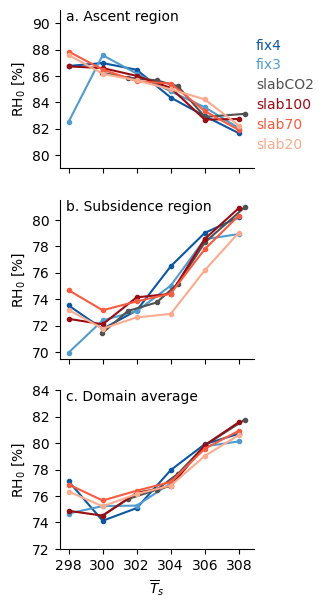

In [50]:
fig, axes = plt.subplots(3, 1, figsize=(2.5, 7), sharex=True)

for ax in axes:
    ax.set_xticks(np.arange(298,310,2))
    ax.set_ylabel('RH$_0$ [%]')
    ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
    for ss in ['top','right']:
        ax.spines[ss].set_visible(False)

for iexp in range(mean.sizes['exp']):
    axes[0].plot(mean.meanSST.isel(exp=iexp), 100*conv.RHbl.isel(exp=iexp), color=colors_exp[iexp], marker='o', markersize=3)
    axes[1].plot(mean.meanSST.isel(exp=iexp), 100*mean.RHbl.where(mean.up==0).mean('x').isel(exp=iexp), color=colors_exp[iexp], marker='o', markersize=3)
    axes[2].plot(mean.meanSST.isel(exp=iexp), 100*mean.RHbl.mean('x').isel(exp=iexp), color=colors_exp[iexp], marker='o', markersize=3)
axes[0].set_ylim(79, 91)
axes[1].set_ylim(69.5, 81.5)
axes[2].set_ylim(72, 84)
axes[0].text(0.03, 1, 'a. Ascent region', transform=axes[0].transAxes, va='top')
axes[1].text(0.03, 1, 'b. Subsidence region', transform=axes[1].transAxes, va='top')
axes[2].text(0.03, 1, 'c. Domain average', transform=axes[2].transAxes, va='top')

axes[2].set_xlabel(r'$\overline{T}_s$')
for i, exp in enumerate(mean.exp.values):
    axes[0].text(309, 88 - 1.5*i, exp, color=colors_exp[i], fontsize=10, ha='left')
#plt.savefig('figures/SI_RH.pdf', bbox_inches='tight')